## Problem Set 2: Merging and regular expressions

**Total points (without extra credit)**: 30 

**Background on the policy context**: here, we're going to use two datasets to practice reshaping, merging, and regular expression patterns. Both datasets relate to the broader issue of which employers might be violating the rights of temporary guestworkers granted visas under the H-2A program. Here are some articles about potential exploitation of guestworkers by firms and inequality caused by minimal oversight:

- News media coverage of labor abuses of temporary guestworkers: https://www.buzzfeednews.com/article/kenbensinger/the-pushovers 
- GAO report on labor abuses of temporary guestworkers: https://www.gao.gov/products/gao-15-154

The following datasets are located in `pset2_inputdata` (need to unzip): 

- `jobs_clean`: a dataset of guestworker jobs posted by many employers, some of whom have been debarred (banned) from the program for labor abuses; others not debarred
- `debar`: a dataset of employers who committed violations of labor regulations meant to protect temporary guestworkers 


You can view a codebook here: https://docs.google.com/spreadsheets/d/1rF9GJEC8pPKxipD0TsoG9DVdqz3EJ-b-BHEtyioAX7I/edit?usp=sharing


In [547]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import os

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1. Reshaping data (13 points total)

Load the following dataset stored in `pset2_inputdata`: `debar.csv`

This represents employers temporarily banned from hiring workers (debar.csv); call this `debar`


View the head()


In [548]:
debar = pd.read_csv("debar.csv")
debar.head()

,Name,"City, State",Violation,Duration,Start date,End date
0,J&J Harvesting,"Leads, ND",Failure to respond to audit (partial response),2 years,1/19/2014,1/18/2016
1,"Stahlman Apiaries, Inc","Selby, SD",Failure to respond to audit (partial response),1 year,2/19/2015,2/14/2016
2,Trust Nursery,"Pulaski, NY",Failure to respond to audit (partial response),1 year,3/21/2014,3/20/2015
3,Anton Fertilizer Inc.,"Dighton, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016
4,"Great Plains Fluid Service, Inc.","Greensburg, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016


## 1.1 (1 point)

Print the number of rows in `debar` versus the number of unique employer names (`Name`). Is there one row per employer or multiple rows for some employers?

In [549]:
debar.shape
debar.nunique()

(114, 6)

Name           98
City, State    86
Violation      18
Duration        8
Start date     71
End date       78
dtype: int64

**ANSWER**: There are 98 unique names and 114 rows, thus some employers have commited multiple violations.

## 1.2 Investigating duplicated rows (2 points)

A. Create a new column in `debar`--`is_repeated`-- that tells us whether an employer (`Name`) is repeated > 1 times

*Hint*: there are multiple ways to solve this but some possibilities to get the list of names that are repeated are:
- Using value_counts() on the `Name` variable and extracting the index from that value counts 
- Using groupby to count the rows attached to one name

B. Print the rows where `is_repeated == True` and interpret

C. Subset to the rows where `is_repeated == True` and save that data as `mult_debar`. Print the head() and shape

In [550]:
#Find the repeats
repeat_count = debar["Name"].value_counts()
repeat = repeat_count[repeat_count > 1].index

#Create is_repeated based on the repeat list
debar["is_repeated"] = debar["Name"].isin(repeat)

#Display just the repeated rows, sorted
debar[debar["is_repeated"] == True].sort_values("Name")

,Name,"City, State",Violation,Duration,Start date,End date,is_repeated
6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,True
30,Annabella Land & Cattle,"Annabella, Utah",Non-payment,1 year,5/9/2014,5/8/2015,True
29,Autumn Hill Orchard,"Groton, MA",Impeding the Audit Process – Non- Response,2 years,7/6/2014,7/5/2016,True
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,True
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,True
28,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, Texas",Impeding the Audit Process – Partial- Response,2 years,7/20/2014,7/19/2016,True
56,Cisco Produce Inc.,"Cairo, GA",Impeding the Audit Process – Non- Response,2 years,12/10/2015,12/9/2017,True
19,Cisco Produce Inc.,"Cairo, GA",Failure to respond to audit (no response),2 years,12/10/2014,12/9/2016,True
103,Dove Creek Farms,"Mount Vernon, TX",Failure to respond to audit request,2 years,2/9/2018,2/8/2018,True
109,Dove Creek Farms,"Mount Vernon, TX",Failure to Respond to Audit Request,2 years,2/9/2018,2/8/2020,True


**Interpretation**: A lot of the companies with double violations are failure to respond to an audit or impending the audit process, usually with a partial or no response. Some are duplicates, with the same information in two tables but others have similar (but still slightly different) times stamps.

In [551]:
#Create mult_debar, which just contains the repeated rows
mult_debar = debar[debar["is_repeated"] == True]
mult_debar.head()
mult_debar.shape

,Name,"City, State",Violation,Duration,Start date,End date,is_repeated
6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,True
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,True
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,True
11,Loewen Harvesting LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,True
12,Rollo Farm Labor Contractor,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,True


(32, 7)

## 1.3 Reshape mult_debar to wide to begin filtering out duplicates (4 points)

You want to separate out two cases:

- Cases where the repeat rows for one employer are due to duplicated data 
- Cases where the repeat rows for one employer represent repeated violations for different issues

There are various ways to check duplicates in this data (eg converting `Violation` to lowercase; replacing spelled-out states with two-dig state codes)

We're going to use the simple rule of:

- A row is a duplicate if, within an employer (defined by Name + City, State), the Start date for each row's violation is the same 

To begin to check this, reshape `mult_debar` to a wide dataframe (`mult_debar_wide`) with the following columns, treating the `Name` and `City, State` as the index for the pivot:

- Name
- City, State
- start_date_viol1
- start_date_viol2

Print the head and shape

In [552]:
#Make the states acronym instead of state names, which are leading to duplicates
mult_debar["City, State"] = mult_debar["City, State"].replace({
    "Georgia": "GA",
    "Texas": "TX",
    "Utah": "UT"}, regex = True)

#Pivot the table
mult_debar_wide = mult_debar.pivot_table(values = "Start date",
                                         index = ["Name", "City, State"],
                                         aggfunc = ["first", "last"],
                                         fill_value = 0)

#Rename the columns
mult_debar_wide.columns = ['start_date_viol1', 'start_date_viol2']
mult_debar_wide
mult_debar_wide.shape

/tmp/ipykernel_85/3448017026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mult_debar["City, State"] = mult_debar["City, State"].replace({


start_date_viol1  \
Name                                    City, State                         
Annabella Land & Cattle                 Annabella, UT            5/9/2014   
Autumn Hill Orchard                     Groton, MA               7/6/2014   
Caddo Creek Ranch, dba Paradise Ranch   Caddo, TX               7/20/2014   
Cisco Produce Inc.                      Cairo, GA              12/10/2014   
Dove Creek Farms                        Mount Vernon, TX         2/9/2018   
F&W Farms                               Ingalls, KS            12/10/2014   
Loewen Harvesting LLC                   Brownfield, TX          8/20/2014   
                                        Brownsville, TX         8/20/2014   
Macky and Brad Farms                    Plains, TX              2/13/2015   
Maple Ridge Custom Services, LLC        Altheimer, AK          11/16/2014   
                                        Altheimer, AR          11/16/2014   
Mark Duncan                             Roosevelt, UT          11/16/2014   
Old Tree Farms/Verpaalen Custom Service Volga, SD              12/11/2014   
Rollo Farm Labor Contractor             Miami, FL               8/23/2014   
SRT Farms                               Morton, TX             11/16/2014   
Sharon Mathis                           Tifton, GA             11/16/2014   
Turner Farms                            Healy, KS                 7/17/19   
Xavier Horne                            Lyons, GA               6/16/2016   

                                                         start_date_viol2  
Name                                    City, State                        
Annabella Land & Cattle                 Annabella, UT            5/9/2014  
Autumn Hill Orchard                     Groton, MA               7/6/2014  
Caddo Creek Ranch, dba Paradise Ranch   Caddo, TX               7/20/2014  
Cisco Produce Inc.                      Cairo, GA              12/10/2015  
Dove Creek Farms                        Mount Vernon, TX         2/9/2018  
F&W Farms                               Ingalls, KS            12/10/2014  
Loewen Harvesting LLC                   Brownfield, TX          8/20/2014  
                                        Brownsville, TX         8/20/2014  
Macky and Brad Farms                    Plains, TX              2/13/2015  
Maple Ridge Custom Services, LLC        Altheimer, AK          11/16/2014  
                                        Altheimer, AR          11/16/2014  
Mark Duncan                             Roosevelt, UT          11/16/2014  
Old Tree Farms/Verpaalen Custom Service Volga, SD               12/1/2014  
Rollo Farm Labor Contractor             Miami, FL               8/23/2014  
SRT Farms                               Morton, TX             11/16/2014  
Sharon Mathis                           Tifton, GA             11/16/2014  
Turner Farms                            Healy, KS                 7/17/19  
Xavier Horne                            Lyons, GA               9/27/2017

(18, 2)

## 1.4 Filter out duplicates from original debar data (6 points)

A. Using `mult_debar_wide`, add a column `is_dup` that takes value of True for cases where start_date_viol1 == start_date_viol2 marking the row as a duplicate

B. Going back to the original long-format data you loaded at the beginning- `debar`
    - For employers where `is_dup == True` as indicated by your wide-format dataframe, only keep `violnum == viol1`
    - For all other employers (so is_dup == False and ones we didnt need to check duplicates for), keep all violnum
    - Remove the `is_repeated` column from the `debar` data

**Hint**: you can complete part B without a for loop; `pd.concat` with axis = 0 (row binding) is one way

Call the resulting dataframe `debar_clean` and print the shape and # of unique employer names

In [553]:
#Create the "is_dup" column
mult_debar_wide["is_dup"] = mult_debar_wide["start_date_viol1"] == mult_debar_wide["start_date_viol2"]
mult_debar_wide_reset = mult_debar_wide.reset_index()

#Rename the States so they match when joined
debar["City, State"] = debar["City, State"].replace({
    "Georgia": "GA",
    "Texas": "TX",
    "Utah": "UT"
}, regex=True)

#DF of unique records
not_repeated = debar[debar["is_repeated"] == False].iloc[:, :-1]

#DF of repeats
repeated = debar[debar["is_repeated"] == True].iloc[:, :-1]

#Join repeated and duplicates
joined = pd.merge(mult_debar_wide_reset, repeated, on = ["Name", "City, State"], how = "left")

#Records that were repeats but not duplicates
not_dup = joined[joined["is_dup"] == False].reset_index(drop = True)
not_dup_clean = not_dup.drop(not_dup.columns[[2, 3, 4]], axis=1)

#Records that were repeats AND duplicates
dup = joined[joined["is_dup"] == True].groupby(["Name", "City, State"]).first().reset_index()
dup_clean = dup.drop(dup.columns[[2, 3, 4]], axis = 1)

#Concat unique records, not duplicates, and newly cleaned repeats
debar_clean = pd.concat([not_dup_clean, dup_clean, not_repeated],axis = 0)
debar_clean
debar_clean.shape
debar_clean["Name"].nunique()

,Name,"City, State",Violation,Duration,Start date,End date
0,Cisco Produce Inc.,"Cairo, GA",Failure to respond to audit (no response),2 years,12/10/2014,12/9/2016
1,Cisco Produce Inc.,"Cairo, GA",Impeding the Audit Process – Non- Response,2 years,12/10/2015,12/9/2017
2,Old Tree Farms/Verpaalen Custom Service,"Volga, SD",WHD Debarment,3 years,12/11/2014,12/10/2017
3,Old Tree Farms/Verpaalen Custom Service,"Volga, SD",Wage Hour Debarment,3 years,12/1/2014,12/1/2017
4,Xavier Horne,"Lyons, GA",Non-payment of certification fee,1 year,6/16/2016,6/15/2017
...,...,...,...,...,...,...
107,Walker Place,"Danville, IL",Failure to comply with the employer's obligati...,2 months,11/19/2019,1/26/2020
108,County Fair Farm (company) and Andrew Williams...,"Jefferson, ME",WHD Debarment,3 years,3/8/2017,3/8/2020
110,Jesus Ledesma,"Mulberry, FL",Failure to Respond to Audit Request,2 years,2/8/18,2/8/20
112,B & R Harvesting and Paul Cruz (individual),"Collins, GA",WHD Debarment,3 years,4/9/17,4/9/20


(103, 6)

98

# 2. Merging and regex (17 points total)



## 2.1 Load data on job postings

The previous dataset contains a small subset of employers who faced temporary bans due to violations of H-2A program regulations

Since most of the bans have expired, we're going to see which of those employers posted new H-2A jobs in the first quarter of 2021 

Loading the `jobs_clean.csv` data stored in `pset4_inputdata`

In [554]:
jobs = pd.read_csv('jobs.csv')
print(jobs.head())

          CASE_NUMBER                           CASE_STATUS  \
0  H-300-20199-721302      Determination Issued - Withdrawn   
1  H-300-20231-773906  Determination Issued - Certification   
2  H-300-20231-774123  Determination Issued - Certification   
3  H-300-20231-774151  Determination Issued - Certification   
4  H-300-20231-774508  Determination Issued - Certification   

             RECEIVED_DATE            DECISION_DATE  \
0  2020-07-17 14:50:40.840  2020-10-01 00:00:00.000   
1  2020-08-20 10:38:15.620  2020-10-01 00:00:00.000   
2  2020-08-24 15:33:14.340  2020-10-01 00:00:00.000   
3  2020-08-21 12:08:09.760  2020-10-01 00:00:00.000   
4  2020-08-20 10:17:34.530  2020-10-01 00:00:00.000   

  TYPE_OF_EMPLOYER_APPLICATION H2A_LABOR_CONTRACTOR NATURE_OF_TEMPORARY_NEED  \
0          Individual Employer                    N                 Seasonal   
1          Association - Agent                    N                 Seasonal   
2          Individual Employer                    

##  2.2 Try inner join on employer name  (2 points)

- Use the `EMPLOYER_NAME` field of the `jobs` dataset
- Use the `Name` field of the `debar_clean` dataset 

A. Use pd.merge with an inner join on those fields to see whether there are any exact matches. 

B. If there are exact matches, print the row(s) with exact matches



In [555]:
## inner join
merged = pd.merge(jobs['EMPLOYER_NAME'], debar_clean['Name'], how='inner', left_on='EMPLOYER_NAME', right_on='Name')

if not merged.empty:
    print(merged)
else:
    print("No exact matches")

    EMPLOYER_NAME            Name
0  Rafael Barajas  Rafael Barajas


## 2.3 Targeted regex (10 points total)

You want to see if you can increase the exact match rate with some basic cleaning of each 
of the employer name fields in each dataset 

### 2.3.1 Converting to upper (2 points)

A. Convert the `EMPLOYER_NAME` and `Name` fields to uppercase using list comprehension rather than df.varname.str.upper() (it's fine to do a separate list comprehension line for each of the two columns)

B. Print a random sample of 15 values of each result

C. Assign the full vector of uppercase names back to the original data, writing over the original `EMPLOYER_NAME` and `Name` columns 


In [556]:
## EMPLOYER_NAME to uppercase
jobs['EMPLOYER_NAME'] = [name.upper() for name in jobs['EMPLOYER_NAME']]
debar_clean['Name'] = [name.upper() for name in debar_clean['Name']]

In [557]:
print(jobs['EMPLOYER_NAME'].sample(15))
print(debar_clean['Name'].sample(15))

2288             GERARD FREY FARMS
837              PHILLIP W. HEBERT
952       HANSEN LIVESTOCK COMPANY
532     TIMBER LAKE ELK RANCH, LLC
1847     G & M BROUSSARD FARM, LLC
1099       POPE BROTHERS DAIRY LLC
2241            KYLE SIEBERT FARMS
302            MAMMOSER FARMS INC.
2097         P. D. DESHOTELS FARMS
734      WESTERN RANGE ASSOCIATION
1392              RUDY'S HONEY LLC
867           BRYAN LEONARDS FARMS
1983                  PAUGH, INC. 
1684              MOOSE FARMS INC.
249                    FAT CAT LLC
Name: EMPLOYER_NAME, dtype: object
81                                 OLSON FARMS
26     RB FARM PICKING INC, DBA RONALD BERNARD
85               TRINITY LIVESTOCK PARTNERSHIP
37                                JOHN R. COOK
20                        SLASH E.V. RANCH LLP
49               CITY PINESTRAW AND HARVESTING
113                                DELIA ROJAS
46                    ALTENDORF TRANSPORT INC.
33                          GERONIMO SHEEP CO.
83               

### 2.3.2 Cleaning up punctuation (4 points)

You notice that INC, CO, and LLC are sometimes followed by a period (.) but sometimes not

A. For each dataset, write a regex pattern using `re.sub` to remove the . but only if it's preceded by INC, LLC, or CO 

Make sure LLC, INC, CO remain part of the string but just without the dot

B. Test the pattern on the positive and negative example we provide below and print the result. See the Github issue for examples of what to return


**Hint**: https://stackoverflow.com/questions/7191209/python-re-sub-replace-with-matched-content



In [558]:
pos_example_1 = "CISCO PRODUCE INC."
pos_example_2 = "AVOYELLES HONEY CO., LLC"
neg_example = "E.V. RANCH LLP"

In [559]:
## insert your code here with the regex pattern for part A
pattern = "(INC|LLC|CO)\."

## insert your code to use re.sub to apply the pattern to the test cases for part B
res_pos_example_1 = re.sub(pattern, "",pos_example_1)
res_pos_example_2 = re.sub(pattern, "", pos_example_2)
res_neg_example = re.sub(pattern, "", neg_example)

print(res_pos_example_1)
print(res_pos_example_2)
print(res_neg_example)

CISCO PRODUCE 
AVOYELLES HONEY , LLC
E.V. RANCH LLP


### 2.3.3 (4 points)

Use that pattern in conjunction with `re.sub` and list comprehension to clean the employer name columns in each dataset. Save the new columns as `name_clean` in each. Then, use row subsetting to (1) subset to rows that changed names and (2) for:

- `debar_clean` print the `Name` and `name_clean` columns
- `jobs` print the `EMPLOYER_NAME` and `name_clean` columns

Make sure to use the uppercase versions of the variables


In [560]:
## Function to clean employer names
def clean_dot(data):
    return [re.sub(pattern, "", x) for x in data]

jobs['name_clean'] = clean_dot(jobs['EMPLOYER_NAME'])
debar_clean['name_clean'] = clean_dot(debar_clean['Name'])

jobs['name_changed'] = np.where(jobs['EMPLOYER_NAME'] == jobs['name_clean'], False, True)
debar_clean['name_changed'] = np.where(debar_clean['Name'] == debar_clean['name_clean'], False, True)

debar_changed = debar_clean[debar_clean['name_changed'] == True]
print(debar_changed[['Name','name_clean']].head(15))
job_changed = jobs[jobs['name_changed'] == True]
print(job_changed[['EMPLOYER_NAME','name_clean']].head(15))

                                Name                    name_clean
0                 CISCO PRODUCE INC.                CISCO PRODUCE 
1                 CISCO PRODUCE INC.                CISCO PRODUCE 
3              ANTON FERTILIZER INC.             ANTON FERTILIZER 
4   GREAT PLAINS FLUID SERVICE, INC.  GREAT PLAINS FLUID SERVICE, 
5                        PROMAX INC.                       PROMAX 
13                     REIMER'S INC.                     REIMER'S 
23                     REIMER’S INC.                     REIMER’S 
33                GERONIMO SHEEP CO.               GERONIMO SHEEP 
46          ALTENDORF TRANSPORT INC.          ALTENDORF TRANSPORT 
72      SAXTONS RIVER ORCHARDS, INC.      SAXTONS RIVER ORCHARDS, 
91          AVOYELLES HONEY CO., LLC         AVOYELLES HONEY , LLC
                                    EMPLOYER_NAME  \
4                         DUNSON HARVESTING, INC.   
7        FARM LABOR ASSOCIATION FOR GROWERS, INC.   
14                             MCLAIN

## 2.4 More joins and more cleaning (5 points)

A. Conduct another inner join between `jobs` and `debar_clean` now using the `name_clean` column; print the result. Did the cleaning result in any more employers matched between the two datasets?

B. Create a new column in `debar_clean` called `name_clean_2` that uses regex to take the following name in that dataset:

- `SLASH E.V. RANCH LLP` in the `debar_clean` dataset

And cleans it up so that it matches with this employer in `jobs`

- `SLASH EV RANCH` in the `jobs` dataset

Eg a pattern to remove the dots in the EV and the space+LLP-- you can apply the pattern to all employer names in debar_clean (so don't need to worry about only applying it to that one employer)


C. Conduct a left join using `name_clean_2` as the join column where the left hand dataframe is `jobs`; right hand dataframe is `debar_clean`, store the result as a dataframe, and print the rows where the merge indicator indicates the row was found in both dataframe

**Note**: this manual cleaning process is inefficient and helps motivate why talked about fuzzy matching. Fuzzy matching could recognize that Slash EV ranch is a highly similar string to slash ev ranch llp and match them without us needing to use regex to make the strings identical.

In [561]:
# Inner join using name_clean 
debar_jobs_inner = pd.merge(jobs, debar_clean, how='inner', on='name_clean')
debar_jobs_inner.head()

pattern = r"\.|\s+LLP"

debar_clean['name_clean_2'] = clean_dot(debar_clean['Name'])
print(debar_clean['name_clean_2'].head(15))

## left join using name_clean_2 
debar_jobs_left = pd.merge(jobs, debar_clean, how='left', left_on='name_clean', right_on='name_clean_2', indicator=True)

both = debar_jobs_left[debar_jobs_left['_merge'] == 'both']
both.head()

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,TOTAL_ADDENDUM_A_RECORDS,name_clean,name_changed_x,Name,"City, State",Violation,Duration,Start date,End date,name_changed_y
0,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,RAFAEL BARAJAS,NaN,...,7,RAFAEL BARAJAS,False,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,False


0                          CISCO PRODUCE INC
1                          CISCO PRODUCE INC
2    OLD TREE FARMS/VERPAALEN CUSTOM SERVICE
3    OLD TREE FARMS/VERPAALEN CUSTOM SERVICE
4                               XAVIER HORNE
5                               XAVIER HORNE
0                    ANNABELLA LAND & CATTLE
1                        AUTUMN HILL ORCHARD
2      CADDO CREEK RANCH, DBA PARADISE RANCH
3                           DOVE CREEK FARMS
4                                  F&W FARMS
5                      LOEWEN HARVESTING LLC
6                      LOEWEN HARVESTING LLC
7                       MACKY AND BRAD FARMS
8           MAPLE RIDGE CUSTOM SERVICES, LLC
Name: name_clean_2, dtype: object


,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,Name,"City, State",Violation,Duration,Start date,End date,name_clean_y,name_changed_y,name_clean_2,_merge
791,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,RAFAEL BARAJAS,NaN,...,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,RAFAEL BARAJAS,False,RAFAEL BARAJAS,both
1115,H-300-20306-894148,Determination Issued - Certification,2020-11-02 18:11:29.140,2020-11-24 00:00:00.000,Individual Employer,N,Seasonal,N,SLASH EV RANCH,NaN,...,SLASH E.V. RANCH LLP,"Rifle, CO",WHD Debarment,1 year,11/15/2014,11/14/2015,SLASH E.V. RANCH LLP,False,SLASH EV RANCH,both


# 3. Optional extra credit 1: regex to separate companies from individuals (1 point)

You notice some employers in `debar_clean` have both the name of the company and the name of individual, e.g.:
    
COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*

Use the uppercase/cleaned `name_clean` in `debar_clean`

A. Write a regex pattern that does the following:
    - Captures the pattern that occurs before COMPANY if (COMPANY) is in string; so in example above, extracts COUNTY FAIR FARM 
    - Captures the pattern that occurs before INDIVIDUAL if (INDIVIDUAL) is also in string -- so in above, extracts ANDREW WILLIAMSON (so omit the "and")
    
B. Test the pattern on `pos_example` and `neg_example`-- make sure former returns a list (if using find.all) or match object (if using re.search) with the company name and individual name separated out; make sure latter returns empty
    
**Hints and resources**: for step A, you can either use re.search, re.match, or re.findall; don't worry about matching B&R Harvesting and Paul Cruz (Individual)

- Same regex resources as above
    

In [567]:
pos_example = "COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*"
neg_example = "CISCO PRODUCE"

#Define a function to create a tuple of the company name and individual name
def extract_names(text):
    pattern = r'^(.*?)(?:\s+\(COMPANY\))\s+AND\s+(.*?)(?=\s+\(INDIVIDUAL\))'
    match = re.search(pattern, text)
    
    if match:
        company = match.group(1).strip() if match.group(1) else None
        individual = match.group(2).strip() if match.group(2) else None
        return company, individual
    else:
        return None, None

#Testing
extract_names(pos_example)
extract_names(neg_example)

('COUNTY FAIR FARM', 'ANDREW WILLIAMSON')

(None, None)

C. Iterate over the `name_clean` column in debar and use regex to create two new columns in `debar_clean`:
   - `co_name`: A column for company (full `name_clean` string if no match; pattern before COMPANY if one extracted)
   - `ind_name`: A column for individual (full `name_clean` string if no match; pattern before INDIVIDUAL if one extracted)
 


In [563]:
#Create empty lists
co_name = []
ind_name = []

#Loop through name_clean column  
for name in debar_clean["name_clean"]:
    extract = extract_names(name)
    if extract[0]:
        if extract[0]: 
            co_name.append(extract[0])
        if extract[1]: 
            ind_name.append(extract[1])
    else:
        co_name.append(name)
        ind_name.append(name)        

debar_clean["co_name"] = co_name
debar_clean["ind_name"] = ind_name

   
D. Print three columns for the rows in `debar_clean` containing the negative example and positive example described above (county fair farm and cisco produce):

- `name_clean`
- `co_name`
- `ind_name`
- `Violation`

**Note**: as shown in the outcome there may be duplicates of the same company reflecting different violations

In [564]:
debar_clean[debar_clean["name_clean"] == pos_example][["name_clean", "co_name", "ind_name", "Violation"]]
debar_clean[debar_clean["name_clean"].str.contains(neg_example)][["name_clean", "co_name", "ind_name", "Violation"]]

,name_clean,co_name,ind_name,Violation
108,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,COUNTY FAIR FARM,ANDREW WILLIAMSON,WHD Debarment


,name_clean,co_name,ind_name,Violation
0,CISCO PRODUCE,CISCO PRODUCE,CISCO PRODUCE,Failure to respond to audit (no response)
1,CISCO PRODUCE,CISCO PRODUCE,CISCO PRODUCE,Impeding the Audit Process – Non- Response


# 4. Optional extra credit 2 (up to 3 points)

- For 1 point extra credit, create a visualization with 1+ of the existing fields in either the raw `jobs` or `debar` data. We'll be showing cool visualizations in class so use your imagination! Options could include visualizing between-state or over-time variation

- For 3 points extra credit instead, geocode the employer addresses in `jobs` and plot the addresses of jobs as points overlaid on top of a map of Georgia 
    - **Note**: this extra credit involves Googling since we have not yet covered spatial data. 
        - For discussion of how to geocode addresses -> lat/long, see: https://www.natasshaselvaraj.com/a-step-by-step-guide-on-geocoding-in-python/ 
        - For discussion of plotting lat/long dots against a map, see this discussion of geopandas: https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    - Relevant columns include `EMPLOYER_ADDRESS_1` 
    - The geocoding might have a long runtime so feel free to implement it in a separate .py script that you submit alongside your notebook and to just read in the geocoded data

<Figure size 800x600 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Job Listings by Frequency of Pay')

Text(0.5, 0, 'Frequency of Pay')

Text(0, 0.5, 'Number of Job Listings')

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Weekly'),
  Text(1, 0, 'Biweekly'),
  Text(2, 0, 'Other'),
  Text(3, 0, 'Monthly')])

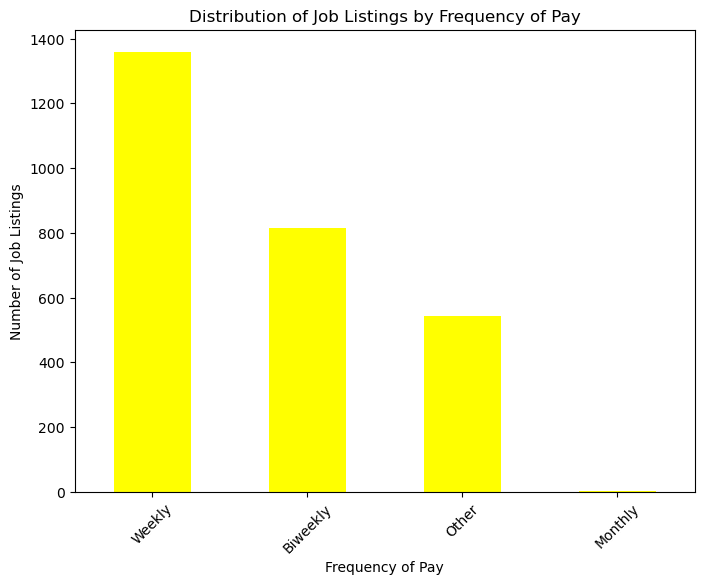

In [565]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
jobs['FREQUENCY_OF_PAY'].value_counts().plot(kind='bar', color='yellow')
plt.title('Distribution of Job Listings by Frequency of Pay')
plt.xlabel('Frequency of Pay')
plt.ylabel('Number of Job Listings')
plt.xticks(rotation=45)
plt.show()